# Versuch E01 - Grundpraktikum Elektronik

In [1]:
%matplotlib inline

from uncertainties import unumpy,umath
from helper import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from scipy.optimize import curve_fit, minimize

#print(plt.style.available)

In [2]:
def plotformat(xlabel='x', ylabel='y', xscale='linear', yscale='linear',\
             title='graph', filename='tmp', style='bmh', yticks=[], xticks=[],\
             formatter=tck.ScalarFormatter):
    
    plt.figure(figsize=(15,10))
    ax = plt.gca()
    plt.style.use(style)
    
    #plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.')
    
    plt.xscale(xscale)
    plt.yscale(yscale)
        
    #ax.yaxis.set_major_formatter(tck.LogFormatter())
    
    #for label in ax.yaxis.get_major_ticks():
    #   print(label.label1)
    
    if len(yticks) > 0:
        plt.yticks(yticks)
        plt.axes().get_yaxis().set_major_formatter(formatter())
    if len(xticks) > 0:
        plt.xticks(xticks)
        plt.axes().get_xaxis().set_major_formatter(formatter())
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    #plt.savefig(filename+'.png')
db = lambda x: 20*np.log10(x)

In [3]:
def fitfunc(freq, vumax, n1, n2, s1, s2):
    return vumax/(np.sqrt(1+(freq/s1)**n1)*np.sqrt(1+(freq/s2)**n2))
def fitfunc2(f, sx1, sx2, ox1, oy):
    #-sy*np.e**(-(sx1*f)-ox1)-
    return oy - np.e**(sx1*(-f+ox1)) - np.e**(sx2*f)+oy

## V1 - Emitterschaltung
### Freqeuenzgangmessung

In [12]:
data = np.genfromtxt('1-freq.dat', dtype=float, skip_header=0, delimiter=',')[2:]

# Inbetriebnahme und Vermessung
init_n = np.array([6.79,0.615,7.94,0.997,0.387,7.20])
init =unumpy.uarray(init_n, init_n*.05/100+.001)
pd.DataFrame(init, index=['$U_{CE}$','$U_{BE}$','$U_{RC}$','$U_{R2}$','$U_E$','$U_C$'], columns=['[V]'])

,[V]
$U_{CE}$,6.790+/-0.004
$U_{BE}$,0.6150+/-0.0013
$U_{RC}$,7.940+/-0.005
$U_{R2}$,0.9970+/-0.0015
$U_E$,0.3870+/-0.0012
$U_C$,7.200+/-0.005


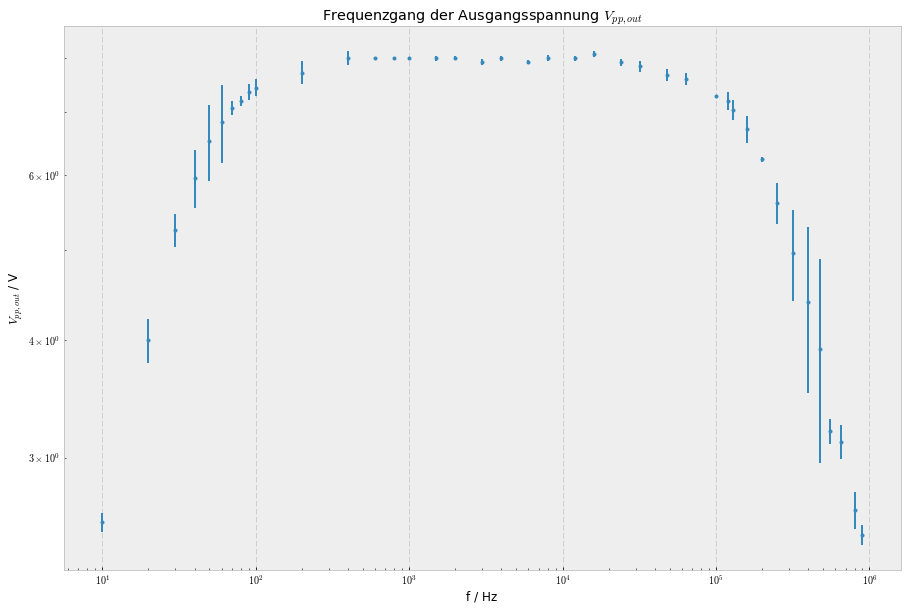

In [14]:
plotformat(xlabel='f / Hz', ylabel='$V_{pp,out}$ / V', xscale='log', yscale='log',\
        title='Frequenzgang der Ausgangsspannung $V_{pp,out}$')
plt.errorbar(data[:,0], data[:,4], xerr=data[:,1], yerr=data[:,5], fmt='.')
plt.savefig('1-freqU.png')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

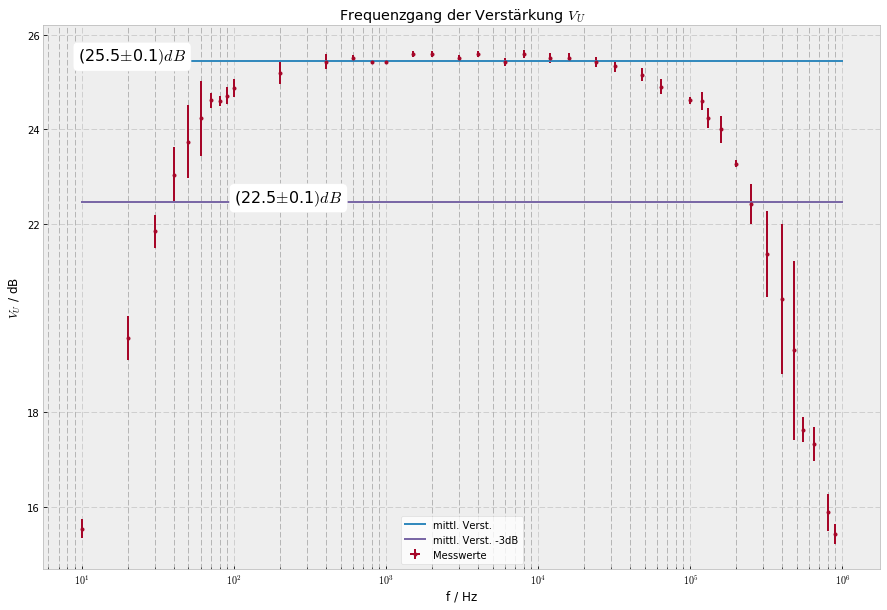

In [6]:
vppin = unumpy.uarray(data[:,2],data[:,3])
vppout = unumpy.uarray(data[:,4],data[:,5])

verst = vppout/vppin*1000

# 200Hz - 64kHz
mean_verst = np.sum(unumpy.nominal_values(verst)[10:26])/16
mean_verst_dev = np.sum(unumpy.std_devs(verst)[10:26])/16
plotformat(xlabel='f / Hz', ylabel='$V_U$ / dB',\
           xscale='log', yscale='linear',\
           title='Frequenzgang der Verstärkung $V_U$',\
           yticks=[14,16,18,22,24,26])
        
fitdata = np.logspace(1,6,1E3)

# mean
plt.plot(fitdata, db([mean_verst for i in range(len(fitdata))]), label='mittl. Verst.')
plt.annotate(r'(%.1f$\pm$%.1f$)dB$' % (db(mean_verst), db(mean_verst+mean_verst_dev)-db(mean_verst)),
             xy=(20, db(mean_verst)), xycoords='data',
             xytext=(-50, 0), textcoords='offset points', fontsize=16,
             bbox=dict(boxstyle="round", fc="1"))

plt.errorbar(data[:,0], db([verst[i].n for i in range(len(verst))]),\
             xerr=data[:,1],\
             yerr=db(unumpy.nominal_values(verst)+unumpy.std_devs(verst)) - db(unumpy.nominal_values(verst)),\
             fmt='.', label='Messwerte')
# mean -3dB
plt.plot(fitdata, db([mean_verst for i in range(len(fitdata))])-3, label='mittl. Verst. -3dB')
plt.annotate(r'(%.1f$\pm$%.1f$)dB$' % (db(mean_verst)-3, db(mean_verst+mean_verst_dev)-db(mean_verst)),
             xy=(100, db(mean_verst)-3), xycoords='data',
             xytext=(0, 0), textcoords='offset points', fontsize=16,
             bbox=dict(boxstyle="round", fc="1"))

plt.grid(b=True, which='minor', color='gray', linestyle='--')

pprint('V_{U,mean}', mean_verst, mean_verst_dev)
pprint('V_{U,mean}', db(mean_verst), db(mean_verst_dev+mean_verst)-db(mean_verst), 'dB')
#print(db(mean_verst)-3)
leg = plt.legend()
leg.get_frame().set_facecolor('white')
plt.savefig('1-freqU.png')
#pd.DataFrame(verst)

### Eingangswiderstand

<IPython.core.display.Math object>

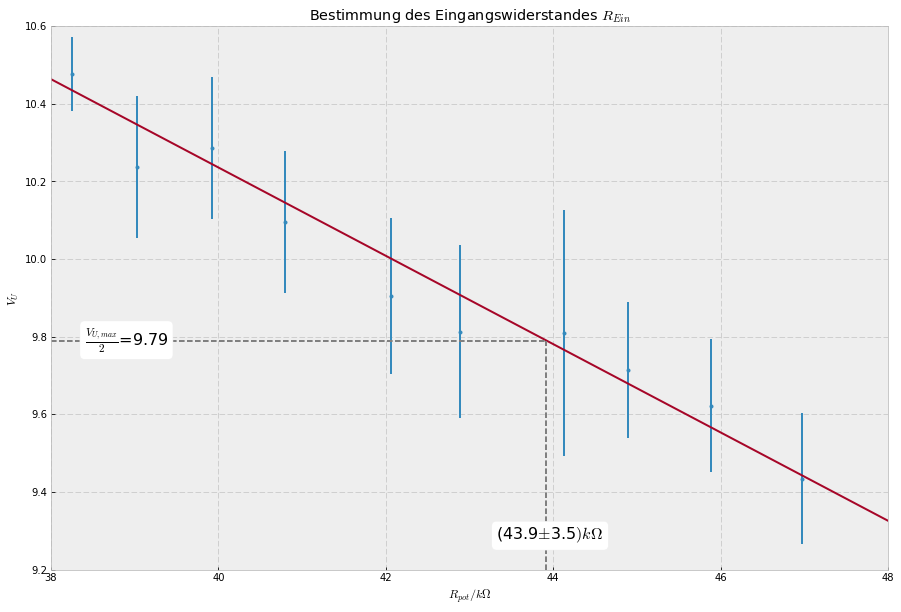

In [7]:
data = np.genfromtxt('1-einohm.dat', dtype=float, skip_header=0, delimiter=',')[2:]
vppin = unumpy.uarray(data[:,2],data[:,3])
vppout = unumpy.uarray(data[:,4],data[:,5])

verst = vppout/vppin*1000
pd.DataFrame(verst)
plt.figure(figsize=(15,10))
plt.errorbar(data[:,0], unumpy.nominal_values(verst), yerr=unumpy.std_devs(verst), fmt='.')

lin = lambda x, m, c: m*x+c
popt, pcov = curve_fit(lin, data[:,0], unumpy.nominal_values(verst),\
                       sigma=unumpy.std_devs(verst))
fitdata = np.linspace(38, 48, 2)
plt.plot(fitdata, lin(fitdata, *popt))

params = unumpy.uarray(popt,np.sqrt(np.diag(pcov)))
x = (9.79-popt[1])/popt[0]
dx = (9.79-params[1])/params[0]
plt.plot([x,x], [9.2, lin(x, *popt)], linestyle='--', color='gray')
plt.plot([38,x], [lin(x, *popt), lin(x, *popt)], linestyle='--', color='gray')
plt.ylim([9.2, 10.6])
plt.xlim([38, 48])

plt.annotate(r'(%.1f$\pm$%.1f$)k\Omega$' % (dx.n, dx.s),
             xy=(x, 9.2), xycoords='data',
             xytext=(-50, +30), textcoords='offset points', fontsize=16,
             bbox=dict(boxstyle="round", fc="1"))
plt.annotate(r'$\frac{V_{U,max}}{2}$=%.2f' % (9.79),
             xy=(39, 9.79), xycoords='data',
             xytext=(-50, -5), textcoords='offset points', fontsize=16,
             bbox=dict(boxstyle="round", fc="1"))
plt.title('Bestimmung des Eingangswiderstandes $R_{Ein}$')
plt.xlabel('$R_{pot} / k\Omega$')
plt.ylabel('$V_U$')
plt.savefig('1-einohm.png')
uprint('R_{Ein}',dx, 'k\Omega')

### Ausgangswiderstand

<IPython.core.display.Math object>

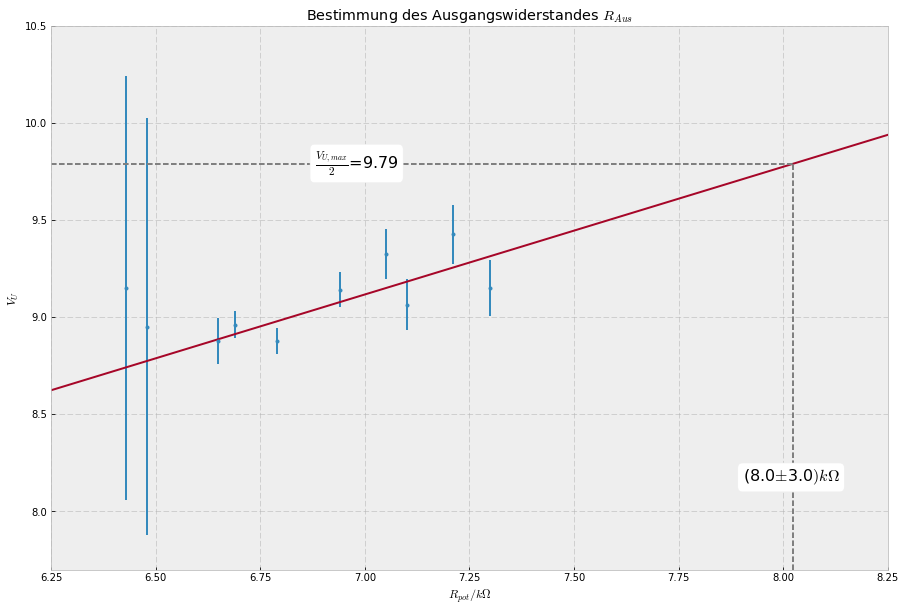

In [8]:
data = np.genfromtxt('1-ausohm.dat', dtype=float, skip_header=0, delimiter=',')[2:]
vppin = unumpy.uarray(data[:,2],data[:,3])
vppout = unumpy.uarray(data[:,4],data[:,5])

verst = vppout/vppin*1000
pd.DataFrame(verst)
plt.figure(figsize=(15,10))
plt.errorbar(data[:,0], unumpy.nominal_values(verst), yerr=unumpy.std_devs(verst), fmt='.')

lin = lambda x, m, c: m*x+c
popt, pcov = curve_fit(lin, data[:,0], unumpy.nominal_values(verst),\
                       sigma=unumpy.std_devs(verst))
fitdata = np.linspace(6.25, 8.25, 2)
plt.plot(fitdata, lin(fitdata, *popt))

params = unumpy.uarray(popt,np.sqrt(np.diag(pcov)))
x = (9.79-popt[1])/popt[0]
dx = (9.79-params[1])/params[0]
plt.plot([x,x], [7.7, lin(x, *popt)], linestyle='--', color='gray')
plt.plot([6.25,x], [lin(x, *popt), lin(x, *popt)], linestyle='--', color='gray')
plt.ylim([7.7, 10.5])
plt.xlim([6.25, 8.25])

plt.annotate(r'(%.1f$\pm$%.1f$)k\Omega$' % (dx.n, dx.s),
             xy=(x, 8), xycoords='data',
             xytext=(-50, +30), textcoords='offset points', fontsize=16,
             bbox=dict(boxstyle="round", fc="1"))
plt.annotate(r'$\frac{V_{U,max}}{2}$=%.2f' % (9.79),
             xy=(7, 9.79), xycoords='data',
             xytext=(-50, -5), textcoords='offset points', fontsize=16,
             bbox=dict(boxstyle="round", fc="1"))
plt.title('Bestimmung des Ausgangswiderstandes $R_{Aus}$')
plt.xlabel('$R_{pot} / k\Omega$')
plt.ylabel('$V_U$')
plt.savefig('1-ausohm.png')
uprint('R_{Aus}',dx,'k\Omega')

## V2 - Kollektorschaltung

In [9]:
init_n = np.array([7.69,0.64,6.78,8.31])
init = unumpy.uarray(init_n, init_n*.05/100+.001)

pd.DataFrame(init, index=['$U_{E}$','$U_{BE}$','$U_{R1}$','$U_{R2}$'], columns=['[V]'])

,[V]
$U_{E}$,7.690+/-0.005
$U_{BE}$,0.6400+/-0.0013
$U_{R1}$,6.780+/-0.004
$U_{R2}$,8.310+/-0.005


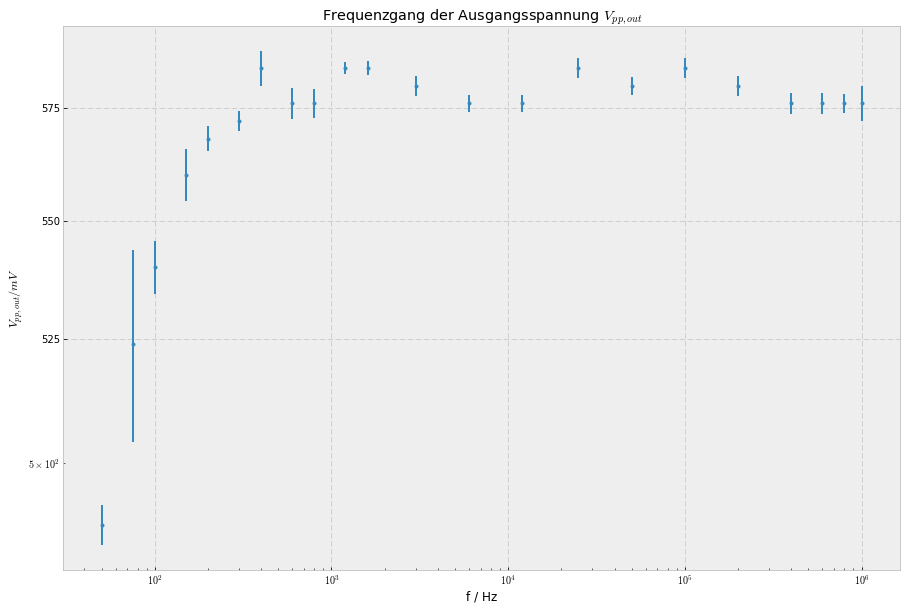

In [10]:
data2 = np.genfromtxt("2-freq.dat", dtype=float, skip_header=0, delimiter=',')[2:]

plotformat(xscale="log", yscale="log", xlabel="f / Hz", ylabel="$V_{pp,out} / mV$",\
           title="Frequenzgang der Ausgangsspannung $V_{pp,out}$",\
           yticks=[475, 525, 550, 575, 600])

plt.errorbar(data2[:,0], data2[:,4], xerr=data2[:,1], yerr=data2[:,5], fmt='.')
plt.savefig('2-freqU.png')
#plt.clf()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

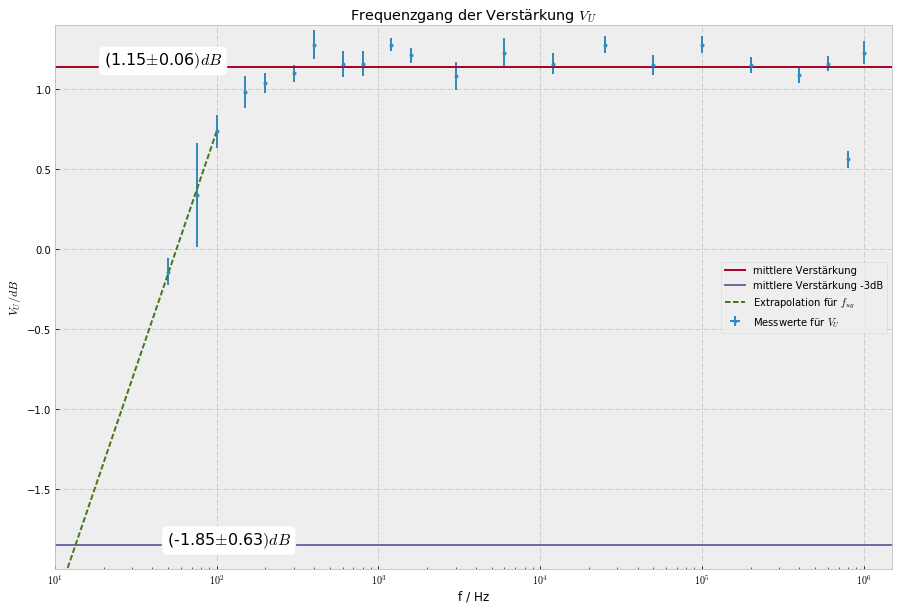

In [15]:
vppout = unumpy.uarray(data2[:,4],data2[:,5])
vppin = unumpy.uarray(data2[:,2],data2[:,3])

verst = vppout/vppin

mean = ufloat(np.mean(unumpy.nominal_values(verst[5:])),np.sum(unumpy.std_devs(verst[5:]))/len(verst[5:]))

plotformat(xscale="log", yscale="linear", yticks=[-1.5, -1,-.5,0, 0.5, 1, 1.5],\
           xlabel="f / Hz", ylabel="$V_U / dB$", title="Frequenzgang der Verstärkung $V_U$",\
           filename='2-freqV')
plt.errorbar(data2[:,0], db(unumpy.nominal_values(verst)),\
             yerr=db(unumpy.std_devs(verst)+unumpy.nominal_values(verst))-db(unumpy.nominal_values(verst)),\
             xerr=data2[:,1], fmt='.', label='Messwerte für $V_U$')
fitdata = np.linspace(10, 1.5E6, 2)
# mean
plt.plot(fitdata, [mean.n, mean.n], label='mittlere Verstärkung')
plt.annotate(r'(%.2f$\pm$%.2f$) dB$' % (db(mean.n), db(mean.n+mean.s)-db(mean.n)),
             xy=(20, db(mean.n)), xycoords='data',
             xytext=(0, 0), textcoords='offset points', fontsize=16,
             bbox=dict(boxstyle="round", fc="1"))

#mean -3dB
plt.plot(fitdata, [db(mean.n)-3, db(mean.n)-3], label='mittlere Verstärkung -3dB')
plt.annotate(r'(%.2f$\pm$%.2f$) dB$' % (db(mean.n)-3, np.abs(db(mean.n+mean.s)-3)-db(mean.n)),
             xy=(100, db(mean.n)-3), xycoords='data',
             xytext=(-50, 0), textcoords='offset points', fontsize=16,
             bbox=dict(boxstyle="round", fc="1"))

m = (verst[2].n-verst[0].n)/(data2[2,0]-data2[0,0])+.0014
y0 = m*10 + verst[2].n - m*data2[2,0]
plt.plot([data2[2,0], 10],[db(verst[2].n), db(y0)], linestyle='--', label='Extrapolation für $f_{ug}$')
plt.xlim([10, 1.5E6])
plt.ylim([-2,1.4])
plt.legend(loc='center right')
plt.savefig('2-freqV.png')
#plt.clf()
#pd.DataFrame(verst)
uprint('V_{U,mean}', mean, '', aftercomma=3)
pprint('V_{U,mean}', db(mean.n), db(mean.n+mean.s)-db(mean.n), 'dB')
vfug = ufloat(db(mean.n)-3, np.abs(db(mean.n+mean.s))-db(mean.n))
uprint('V_{U,mean}-3dB', vfug, 'dB')

sp = (10**(ufloat(vfug.n,mean.s)/20)+m*data2[2,0]-verst[2])/m
uprint('f_{ug}', sp, 'Hz')